In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from scipy import sparse
import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
from dgl.dataloading import GraphDataLoader
from dgl.data import DGLDataset
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
gamma_tree = uproot.open(
    "/home2/chenxu/work/corsika/50GeV_1TeV_zen0.gamma.root:tCorsika"
)
P_tree = uproot.open(
    "/home2/chenxu/work/corsika/100GeV_10TeV_zen0.proton.root:tCorsika"
)

In [4]:
gamma_prie = np.array(gamma_tree["evth/fLia[312]"].array()[:, 3])
P_prie = np.array(P_tree["evth/fLia[312]"].array()[:, 3])

In [5]:
gamma_secs = gamma_tree["secParticles/secParticles.fLia[8]"].array()
P_secs = P_tree["secParticles/secParticles.fLia[8]"].array()

In [6]:
secs = list()
nparticle = list()
for i in range(len(gamma_secs)):
    secs.append(gamma_secs[i])
    nparticle.append(len(gamma_secs[i]))
for i in range(len(gamma_secs)):
    secs.append(P_secs[i])
    nparticle.append(len(P_secs[i]))
secs = np.array(secs, dtype=object)
nparticle = np.array(nparticle)

In [ ]:
sectype = list()
for i in range(100000):
    sectype.append(np.floor(np.array(gamma_secs[i])[:, 0] / 1000).astype(int))
    sectype.append(np.floor(np.array(P_secs[i])[:, 0] / 1000).astype(int))
sectype = np.concatenate(sectype)
sectype = list(set(sectype))

In [ ]:
sectype

In [7]:
secstypes = [[1, 2, 3], [5, 6], [8, 9, 13, 14, 15, 25, 10, 11, 12, 201, 18]]

In [ ]:
sec = np.array(P_secs[0])
sec = sec[:, :-1]
xbins = np.linspace(-500 * 100, 500 * 100, 225)
ybins = np.linspace(-500 * 100, 500 * 100, 225)
for i in sectype:
    print(i)
    H, _, _ = np.histogram2d(
        sec[:, 4][np.isin((sec[:, 0] / 1000).astype(int), i)],
        sec[:, 5][np.isin((sec[:, 0] / 1000).astype(int), i)],
        bins=(xbins, ybins),
    )
    H = H.T
    print(np.max(H))
    X, Y = np.meshgrid(xbins, ybins)
    plt.pcolormesh(X, Y, H)
    plt.show()

In [8]:
gamma_log10energy = np.log10(gamma_prie).astype(np.float32)
P_log10energy = np.log10(P_prie).astype(np.float32)
log10energy = np.concatenate([gamma_log10energy, P_log10energy])

In [9]:
isgamma = np.zeros_like(log10energy, dtype=int)
isgamma[: len(gamma_log10energy)] = 1

In [10]:
class MCDataset_dgl(DGLDataset):
    def __init__(self, isgamma, secs):
        self.secs = secs
        self.isgamma = isgamma
        self.secstypes = [
            [1, 2, 3],
            [5, 6],
            [8, 9, 13, 14, 15, 25, 10, 11, 12, 201, 18],
        ]
        self.xmax = 50 * 100
        self.ymax = 50 * 100
        self.enc = OneHotEncoder()
        self.enc.fit(np.arange(3).reshape(-1, 1))
        super().__init__(name="corsika_data")

    def process(self):
        self.graphs = list()
        self.isgamma_need = list()
        seccount = 0
        for secs in tqdm(self.secs, mininterval=1):
            secs = np.array(secs)
            secs = secs[
                np.where(
                    (np.abs(secs[:, 4]) < self.xmax) & (np.abs(secs[:, 5]) < self.ymax)
                )
            ]
            secslen = len(secs)
            if secslen < 30:
                seccount += 1
                continue
            #             print(secslen)
            self.isgamma_need.append(self.isgamma[seccount])
            seccount += 1
            src = list()
            dst = list()
            secstype_new = 0
            for secstype in self.secstypes:
                secs[:, 0][
                    np.isin((secs[:, 0] / 1000).astype(int), secstype)
                ] = secstype_new
                secstype_new += 1

            xdata = np.zeros([secslen, 9], dtype=np.float32)
            xdata[:, :3] = self.enc.transform(secs[:, 0].reshape(-1, 1)).toarray()
            xdata[:, 3:6] = secs[:, 1:4]
            xdata[:, 6:8] = secs[:, 4:6] / self.xmax
            xdata[:, 8] = (secs[:, 6] - np.mean(secs[:, 6])) * 30 / self.xmax
            for i in range(secslen - 1):
                for j in range(secslen - 1 - i):
                    src.append(i)
                    dst.append(j + i + 1)
            g = dgl.graph((src, dst), num_nodes=secslen)
            g.ndata["xdata"] = torch.from_numpy(xdata)
            self.graphs.append(g)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, index):
        return (
            self.graphs[index],
            self.isgamma_need[index],
        )

In [13]:
train_index, test_index = train_test_split(
    range(len(isgamma)), random_state=42, test_size=0.7
)
test_index_0, test_index_1 = train_test_split(
    test_index, random_state=42, test_size=0.7
)

In [14]:
MCdataset_train = MCDataset_dgl(isgamma[train_index], secs[train_index])
MCdataset_test = MCDataset_dgl(isgamma[test_index_0], secs[test_index_0])

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/42000 [00:00<?, ?it/s]

In [32]:
train_dataloader = GraphDataLoader(MCdataset_train, batch_size=64, drop_last=False)
test_dataloader = GraphDataLoader(MCdataset_test, batch_size=64, drop_last=False)

In [35]:
from dgl.nn.pytorch.conv import GINConv
from dgl.nn.pytorch.glob import SumPooling,AvgPooling


class MLP(nn.Module):
    """Construct two-layer MLP-type aggreator for GIN model"""

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linears = nn.ModuleList()
        # two-layer MLP
        self.linears.append(nn.Linear(input_dim, hidden_dim, bias=False))
        self.linears.append(nn.Linear(hidden_dim, output_dim, bias=False))
        self.batch_norm = nn.BatchNorm1d((hidden_dim))

    def forward(self, x):
        h = x
        h = F.relu(self.batch_norm(self.linears[0](h)))
        return self.linears[1](h)


class GIN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.ginlayers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        num_layers = 5
        # five-layer GCN with two-layer MLP aggregator and sum-neighbor-pooling scheme
        for layer in range(num_layers - 1):  # excluding the input layer
            if layer == 0:
                mlp = MLP(input_dim, hidden_dim, hidden_dim)
            else:
                mlp = MLP(hidden_dim, hidden_dim, hidden_dim)
            self.ginlayers.append(
                GINConv(mlp, learn_eps=False)
            )  # set to True if learning epsilon
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
        # linear functions for graph sum poolings of output of each layer
        self.linear_prediction = nn.ModuleList()
        for layer in range(num_layers):
            if layer == 0:
                self.linear_prediction.append(nn.Linear(input_dim, output_dim))
            else:
                self.linear_prediction.append(nn.Linear(hidden_dim, output_dim))
        self.drop = nn.Dropout(0.5)
        self.pool = (
            AvgPooling()
        )  # change to mean readout (AvgPooling) on social network datasets

    def forward(self, g, h):
        # list of hidden representation at each layer (including the input layer)
        hidden_rep = [h]
        for i, layer in enumerate(self.ginlayers):
            h = layer(g, h)
            h = self.batch_norms[i](h)
            h = F.relu(h)
            hidden_rep.append(h)
        score_over_layer = 0
        # perform graph sum pooling over all nodes in each layer
        for i, h in enumerate(hidden_rep):
            pooled_h = self.pool(g, h)
            score_over_layer += self.drop(self.linear_prediction[i](pooled_h))
        return score_over_layer

In [36]:
model = GIN(9, 64, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for epoch in range(20):
    sumloss = list()
    print(epoch)
    for batched_graph, labels in train_dataloader:
        batched_graph, labels = batched_graph.to(device), labels.to(device)
        pred = model(batched_graph, batched_graph.ndata["xdata"])
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        sumloss.append(loss.item())
        optimizer.step()
    print(f"loss:{np.mean(sumloss):.4f}")

0
loss:0.4742
1
loss:0.3976
2
loss:0.3748
3
loss:0.3615
4
loss:0.3504
5
loss:0.3456
6
loss:0.3349
7
loss:0.3306
8
loss:0.3299
9
loss:0.3260
10
loss:0.3170
11
loss:0.3187
12
loss:0.3105
13
loss:0.3122
14
loss:0.3115
15
loss:0.3062
16
loss:0.3062
17
loss:0.3030
18
loss:0.2968
19
loss:0.2950


In [37]:
model.eval()
count1 = 0
count2 = 0
m = nn.Softmax(dim=1)
y_pred = list()
y_orgin = list()
with torch.no_grad():
    for batched_graph, labels in test_dataloader:
        batched_graph, labels = batched_graph.to(device), labels.to(device)
        pred = model(batched_graph, batched_graph.ndata["xdata"])
        pred = m(pred)
        y_pred.append(pred[:, 1].cpu().numpy())
        y_orgin.append(labels.cpu().numpy())

In [38]:
y_pred = np.concatenate(y_pred)
y_orgin = np.concatenate(y_orgin)

(0.0, 0.3)

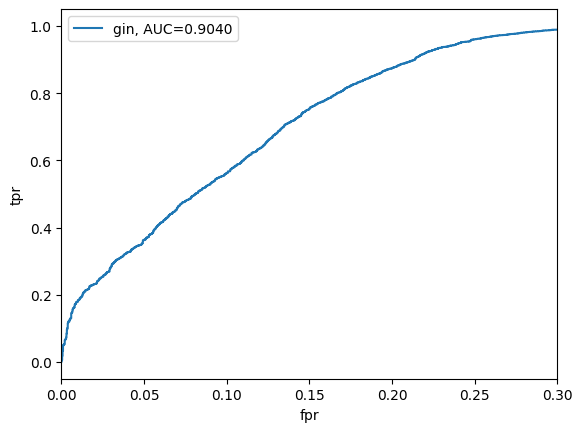

In [40]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_orgin, y_pred)
auc = metrics.roc_auc_score(y_orgin, y_pred)
plt.plot(fpr, tpr, label=f"gin, AUC={auc:.4f}")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()
plt.xlim(0, 0.3)